# Black Lives Matter: Topic Modeling

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/opardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# spacy for lemmatization
import spacy

In [5]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## Import data

In [9]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [10]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-670a48d72abe.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-670a48d72abe.json


In [11]:
%load_ext google.cloud.bigquery

In [12]:
%%bigquery df
SELECT DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2 AND is_retweet = FALSE

In [13]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [14]:
tweet = 'News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'man', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [16]:
stop_words.extend(['ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown', 'url'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'man', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'man', 'shot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [20]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized =  unique_list_of_lists(remove_stopwords(
    lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
))

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'man', 'shoot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(118, 1), (127, 1), (136, 1), (219, 1), (240, 1), (286, 1), (584, 1), (602, 1), (1072, 1), (1704, 1), (12450, 1)]


In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('shoot', 1),
  ('news', 1),
  ('charge', 1),
  ('man', 1),
  ('arrest', 1),
  ('video', 1),
  ('ericgarner', 1),
  ('apparent', 1),
  ('hold', 1),
  ('choke', 1),
  ('firearm', 1)]]

### LDA Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

In [73]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=10,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)

In [75]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [57]:
"""
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=10, 
                                                   random_state=2019,
                                                   chunksize=2000,
                                                   passes=5,
                                                   alpha='symmetric',
                                                   decay=0.5,
                                                   offset=10,
                                                   per_word_topics=True,
                                                   workers=6)
"""

This will give us 10 different topics (a fixed parameter we used). Now, we are going to explore the 10 words most representative of each of these topics. 

In [76]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('black', 0.0303984587740585),
   ('thug', 0.012318692921845766),
   ('cnn', 0.01174443806383491),
   ('whiteasian', 0.010744123149880517),
   ('furacism', 0.010688550099105274),
   ('pandadaomey', 0.01067002574884686),
   ('rttshirt', 0.010651501398588444),
   ('tcot', 0.009021358575847953),
   ('white', 0.008650871570679659),
   ('racist', 0.008502676768612341)]),
 (1,
  [('family', 0.024820265281286114),
   ('justice', 0.017457022181769838),
   ('peace', 0.01439923095016516),
   ('pray', 0.01040058087806674),
   ('today', 0.009285867686612192),
   ('love', 0.00924496078050377),
   ('funeral', 0.008784758086784002),
   ('people', 0.007966619964615526),
   ('stl', 0.0073530163729891695),
   ('rip', 0.007138255115919945)]),
 (2,
  [('people', 0.022129747672768384),
   ('black', 0.014709065980323769),
   ('justice', 0.01218338825680129),
   ('police', 0.01170230678565415),
   ('america', 0.009338994058643831),
   ('happen', 0.007919803718759772),
   ('racism', 0.0076371683544608

Finally, we will obtain the coherence score, a metric that will indicate how good the model fit is.

In [77]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3533378015723692


### Choosing the number of topics

As we mentioned before, the number of topics was fixed to 10. However, we would like to optimize that hyper-parameter as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [80]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [81]:
# Can take a long time to run.
limit = 18
start = 6
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit,
                                                        step=step)

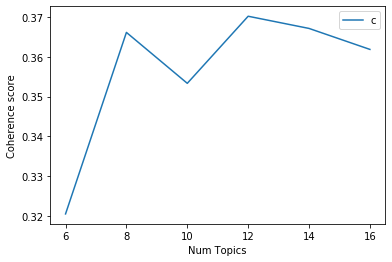

In [82]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.3206
Num Topics = 8  has Coherence Value of 0.3661
Num Topics = 10  has Coherence Value of 0.3533
Num Topics = 12  has Coherence Value of 0.3702
Num Topics = 14  has Coherence Value of 0.3671
Num Topics = 16  has Coherence Value of 0.3618


### Working with the optimal model

The model we liked the most was the one with 8 topics. Although the 4-theme model has the best performance, the 8-theme balances the diversity of topics with acceptable performance.

In [84]:
optimal_model = model_list[3]

In [85]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('protest', 0.022564508583150393),
   ('justice', 0.021754777413898585),
   ('rally', 0.020693129880879547),
   ('solidarity', 0.019739446503760753),
   ('nmos', 0.019001691438442436),
   ('march', 0.017958037931406774),
   ('support', 0.015043005722100263),
   ('dontshoot', 0.01293770468204556),
   ('stand', 0.010796415590024111),
   ('today', 0.010238600784539533)]),
 (1,
  [('justice', 0.028102193798364282),
   ('family', 0.023941351943377327),
   ('peace', 0.017975277114269047),
   ('people', 0.01631314187590124),
   ('pray', 0.012768721036467907),
   ('today', 0.009136240051955485),
   ('community', 0.008971127279932194),
   ('love', 0.008861052098583332),
   ('rip', 0.007969443129657557),
   ('stl', 0.00781533787576915)]),
 (2,
  [('people', 0.019998342678783525),
   ('black', 0.01811313979504461),
   ('white', 0.010613761290500788),
   ('america', 0.009260282297047206),
   ('racism', 0.008707841891555948),
   ('make', 0.007140292240974505),
   ('happen', 0.00696074910918

## Exploring the results

### Dominant topic in each sentence

In [112]:
def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


import multiprocessing
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    words = list(sent_to_words(texts))
    
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 7   # arbitrary default
    
    pool = multiprocessing.Pool(processes=cpus)
    dom_topics_list = pool.map(get_dominant_topic, list(ldamodel[corpus]))
    pool.close()
    
    df_dominant_topic = pd.DataFrame(dom_topics_list)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    df_dominant_topic = pd.concat([df_dominant_topic, contents, bow], axis=1).reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Words']
    
    topic_keywords_dict = get_topic_keywords_dict(ldamodel)
    df_dominant_topic['Topic_Keywords'] = list(map(
        lambda x:topic_keywords_dict[x],
        df_dominant_topic['Dominant_Topic']
    ))
    df_dominant_topic = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text', 'Words']]
    
    return(df_dominant_topic)


def get_dominant_topic(topics):
    topic_num, prop_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
    prop_topic = round(prop_topic,4)
    return(topic_num, prop_topic)


def get_topic_keywords_dict(ldamodel):
    topic_keywords_dict = {}
    for topic in ldamodel.show_topics(formatted=False, num_topics=20):
        topic_num, topic_keywords = topic
        topic_keywords = ", ".join([word for word, prop in topic_keywords])
        topic_keywords_dict[topic_num] = topic_keywords
    return(topic_keywords_dict)

In [93]:
corpus_ = create_corpus(data)
df_dominant_topic = format_topics_sentences(optimal_model, corpus_, data)

In [94]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,Words
0,0,11,0.9358,"cnn, speak, funeral, live, msnbc, watch, talk, family, show, discuss",video pastor compares michael brown to jesus christ; pushes obama initiatives at funeral ➜ $URL$ ferguson,"[video, pastor, compares, michael, brown, to, jesus, christ, pushes, obama, initiatives, at, funeral, url, ferguson]"
1,1,9,0.9268,"shoot, shooting, missouri, video, protest, live, police, follow, news, watch",bazaar daily news photos emerge from scene of michael brown murder ferguson $URL$,"[bazaar, daily, news, photos, emerge, from, scene, of, michael, brown, murder, ferguson, url]"
2,2,2,0.9240,"people, black, white, america, racism, make, happen, medium, murder, police",racism isn’t simply bigotry it’s about dignity and denigration the humanity of michael brown $URL$ ferguson,"[racism, isn, simply, bigotry, it, about, dignity, and, denigration, the, humanity, of, michael, brown, url, ferguson]"
3,3,4,0.5992,"cop, kill, police, black, shoot, darrenwilson, officer, murder, unarmed, man",jeremymallin cnn abc nbc msnbc blacklivesmatter mikebrown ferguson whites dont have to fear the police racistcops hate blacks,"[jeremymallin, cnn, abc, nbc, msnbc, mikebrown, ferguson, whites, dont, have, to, fear, the, police, racistcops, hate, blacks]"
4,4,11,0.9163,"cnn, speak, funeral, live, msnbc, watch, talk, family, show, discuss",reason 89548 why i cant stand this dude donlemon ferguson sideeye ripmikebrown mikebrown… $URL$,"[reason, why, cant, stand, this, dude, donlemon, ferguson, sideeye, ripmikebrown, mikebrown, url]"
5,5,8,0.3700,"police, justice, case, death, investigation, govjaynixon, shoot, obama, grandjury, missouri",second autopsy ordered on body of missouri teen michaelbrown $URL$ via torontostar ferguson,"[second, autopsy, ordered, on, body, of, missouri, teen, michaelbrown, url, via, torontostar, ferguson]"
6,6,1,0.7950,"justice, family, peace, people, pray, today, community, love, rip, stl",the world is watching fergusonshooting michaelbrown fergusonriot,"[the, world, is, watching, michaelbrown, fergusonriot]"
7,7,4,0.5422,"cop, kill, police, black, shoot, darrenwilson, officer, murder, unarmed, man",ferguson whos in charge?mtmtjbouie all of this repression because the police killed a kid and the community wants answers mikebrown,"[ferguson, whos, in, charge, mtmtjbouie, all, of, this, repression, because, the, police, killed, kid, and, the, community, wants, answers, mikebrown]"
8,8,11,0.5277,"cnn, speak, funeral, live, msnbc, watch, talk, family, show, discuss",dear donlemon no signed everyone ferguson mikebrown,"[dear, donlemon, no, signed, everyone, ferguson, mikebrown]"
9,9,10,0.7271,"police, officer, shoot, darrenwilson, video, release, cop, kill, chief, robbery",video of michael brown convenience store robbery — ferguson $URL$ p2 uniteblue inners maddow nyc,"[video, of, michael, brown, convenience, store, robbery, ferguson, url, uniteblue, inners, maddow, nyc]"


### Most representative tweets

In [95]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
df_dominant_topic_sorted = pd.DataFrame()

df_dominant_topic_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in df_dominant_topic_grpd:
    df_dominant_topic_sorted = pd.concat([df_dominant_topic_sorted, 
                                         grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                         axis=0)

# Reset Index    
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)

# Format
df_dominant_topic_sorted.columns = ['Document_No','Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Words', 'Topic_Keywords']

# Show
df_dominant_topic_sorted

,Document_No,Topic_Num,Topic_Perc_Contrib,Text,Words,Topic_Keywords
0,126377,0,0.9590,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",youranonnews opferguson national day of rage orlando lake eola park 7pm thursday august 21st ferguson mikebrown stopkillingus,"[youranonnews, opferguson, national, day, of, rage, orlando, lake, eola, park, pm, thursday, august, st, ferguson, mikebrown, stopkillingus]"
1,142045,0,0.9590,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",national day of rage losangeles 14aug14 4pm leimert plaza park 4395 leimert blvd l a ca 90008 ferguson opferguson mikebrown occupy,"[national, day, of, rage, losangeles, aug, pm, leimert, plaza, park, leimert, blvd, ca, ferguson, opferguson, mikebrown, occupy]"
2,134256,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",join uuberkeley tonight at a prayer vigil for mikebrown and ferguson 7pm miracle temple 2425 cutting blvd richmond berkeley via uuber,"[join, uuberkeley, tonight, at, prayer, vigil, for, mikebrown, and, ferguson, pm, miracle, temple, cutting, blvd, richmond, berkeley, via, uuber]"
3,35505,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",tonight !december 12 movement harlem demo nyc stand with ferguson tonight 6p harlem malcolm x blvd and 125th street mikebrown,"[tonight, december, movement, harlem, demo, nyc, stand, with, ferguson, tonight, harlem, malcolm, blvd, and, th, street, mikebrown]"
4,18667,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",ferguson emergency action in oakland today 4pm 14th and broadway also taking place in sf same time at powell bart dontshoot mikebrown,"[ferguson, emergency, action, in, oakland, today, pm, th, and, broadway, also, taking, place, in, sf, same, time, at, powell, bart, dontshoot, mikebrown]"
5,94068,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",will be live tweeting houstons hands up turn up national day of action for mike brown today at 6pm 2202 st emanuel st ferguson,"[will, be, live, tweeting, houstons, hands, up, turn, up, national, day, of, action, for, mike, brown, today, at, pm, st, emanuel, st, ferguson]"
6,140318,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",&gt;6pm&lt; mpls solidarity rally 4 mike brown and victims of police brutality ferguson thurs 8 28 6pm hnnpn cty gvmt ctr $URL$,"[gt, pm, lt, mpls, solidarity, rally, mike, brown, and, victims, of, police, brutality, ferguson, thurs, pm, hnnpn, cty, gvmt, ctr, url]"
7,159645,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",all my la peeps anonkopimi national day of rage losangeles 14aug14 4pm leimert plaza park 4395 leimert blvd ferguson mikebrown”,"[all, my, la, peeps, anonkopimi, national, day, of, rage, losangeles, aug, pm, leimert, plaza, park, leimert, blvd, ferguson, mikebrown]"
8,159216,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",mikebrown ferguson rally today 5pm uncg on euc lawn rt socialjustice guilfordcollege ncatsuaggies bennettcollege wxii myfox8,"[mikebrown, ferguson, rally, today, pm, uncg, on, euc, lawn, rt, socialjustice, guilfordcollege, ncatsuaggies, bennettcollege, wxii, myfox]"
9,48458,0,0.9557,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",mt “rkbtwo dc natl moment of silence honoring mikebrown malcolm x prk tnt 7pm ferguson sunniandthecity angela_rye” dreamdefenders,"[mt, rkbtwo, dc, natl, moment, of, silence, honoring, mikebrown, malcolm, prk, tnt, pm, ferguson, sunniandthecity, angela_rye, dreamdefenders]"


### Topic Distribution

In [96]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"protest, justice, rally, solidarity, nmos, march, support, dontshoot, stand, today",10905,0.0668
1,1,"justice, family, peace, people, pray, today, community, love, rip, stl",16738,0.1026
2,2,"people, black, white, america, racism, make, happen, medium, murder, police",24207,0.1484
3,3,"closerlook, allstar, pdmsnbc, black, whiteasian, furacism, pandadaomey, rttshirt, lookpd, darrenwilson",4324,0.0265
4,4,"cop, kill, police, black, shoot, darrenwilson, officer, murder, unarmed, man",20385,0.1250
5,5,"time, shoot, shot, head, autopsy, autopsyshow, rt, shotleast, nytime, show",7040,0.0432
6,6,"read, darrenwilson, dontshoot, policebrutality, rt, support, school, stlouis, gofundme, share",7345,0.0450
7,7,"police, protester, protest, tearga, cop, arrest, people, shoot, street, stl",15255,0.0935
8,8,"police, justice, case, death, investigation, govjaynixon, shoot, obama, grandjury, missouri",12457,0.0764
9,9,"shoot, shooting, missouri, video, protest, live, police, follow, news, watch",11716,0.0718


## Visualization

### Length

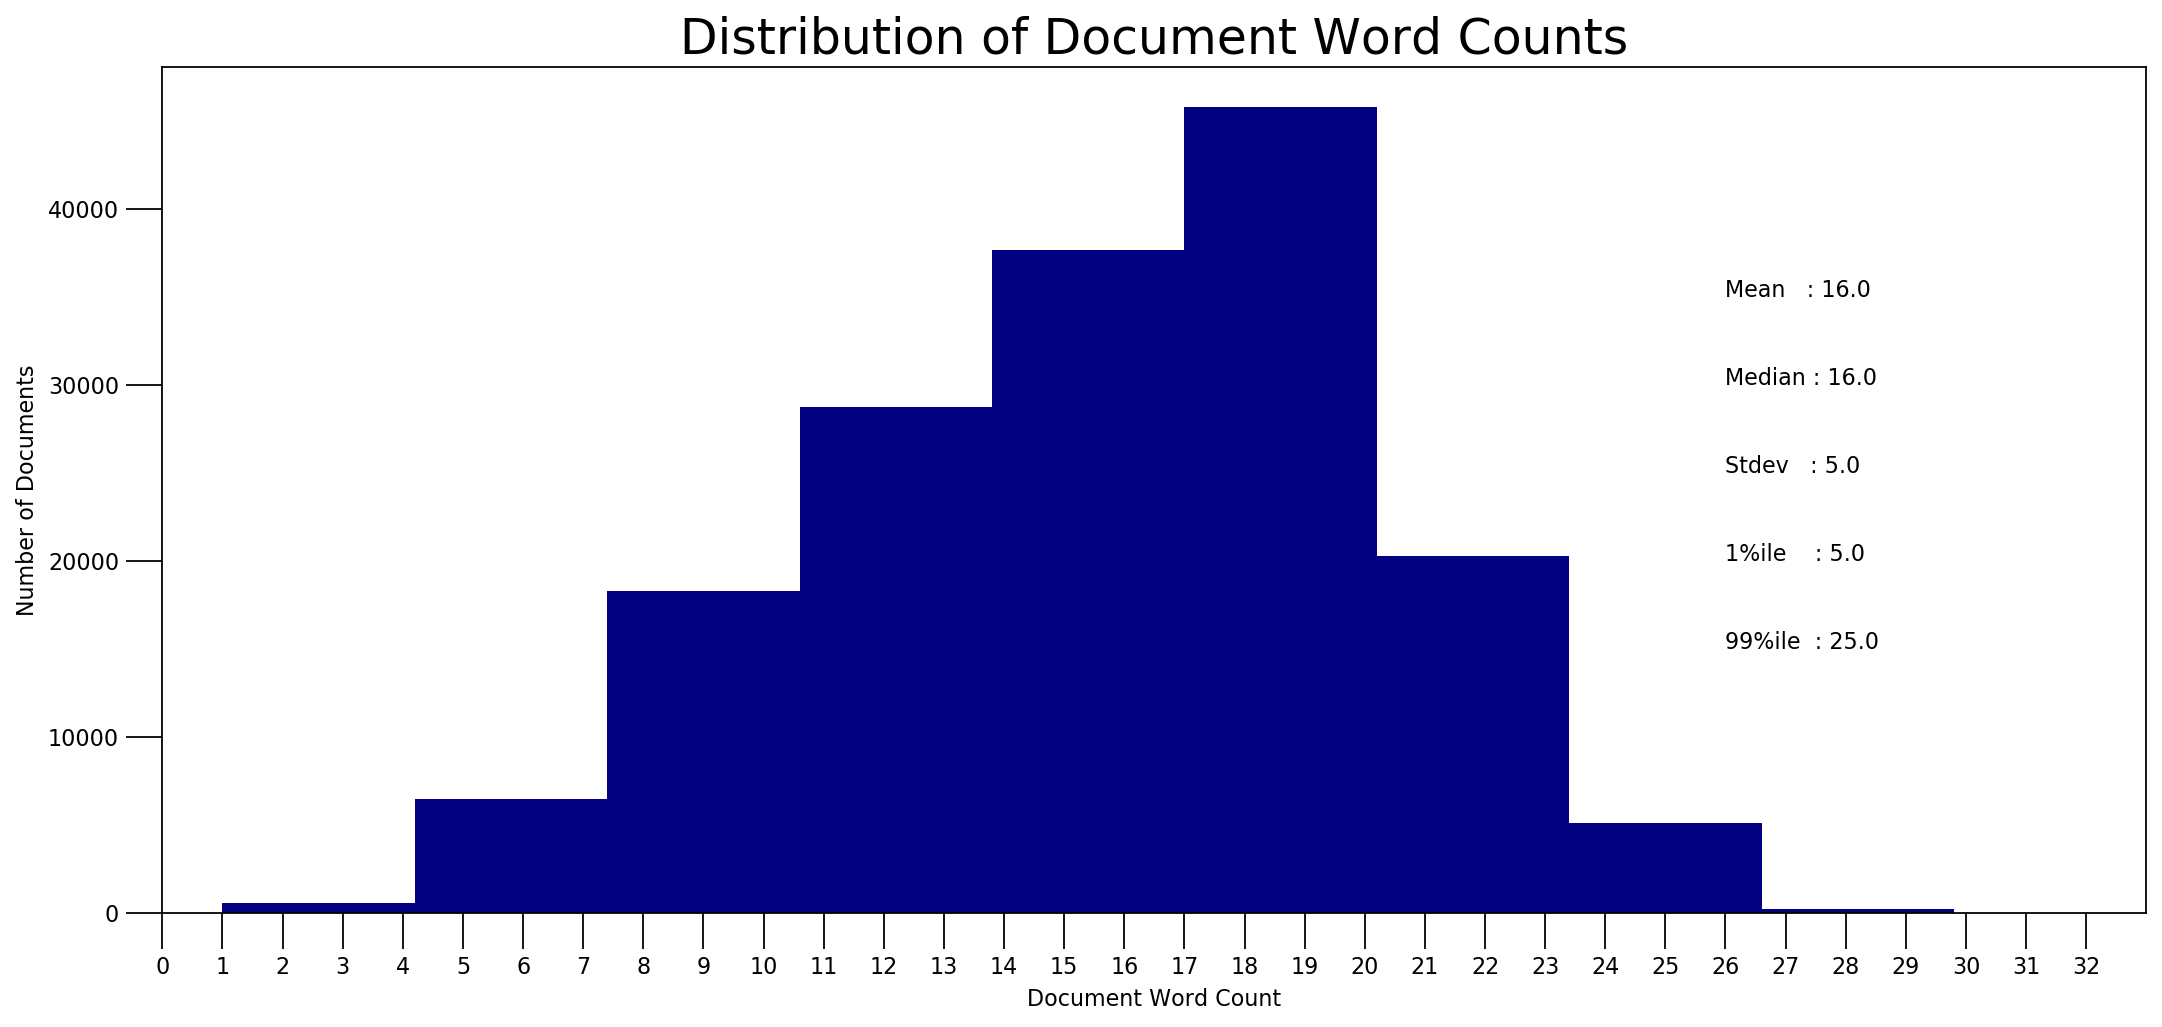

In [97]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

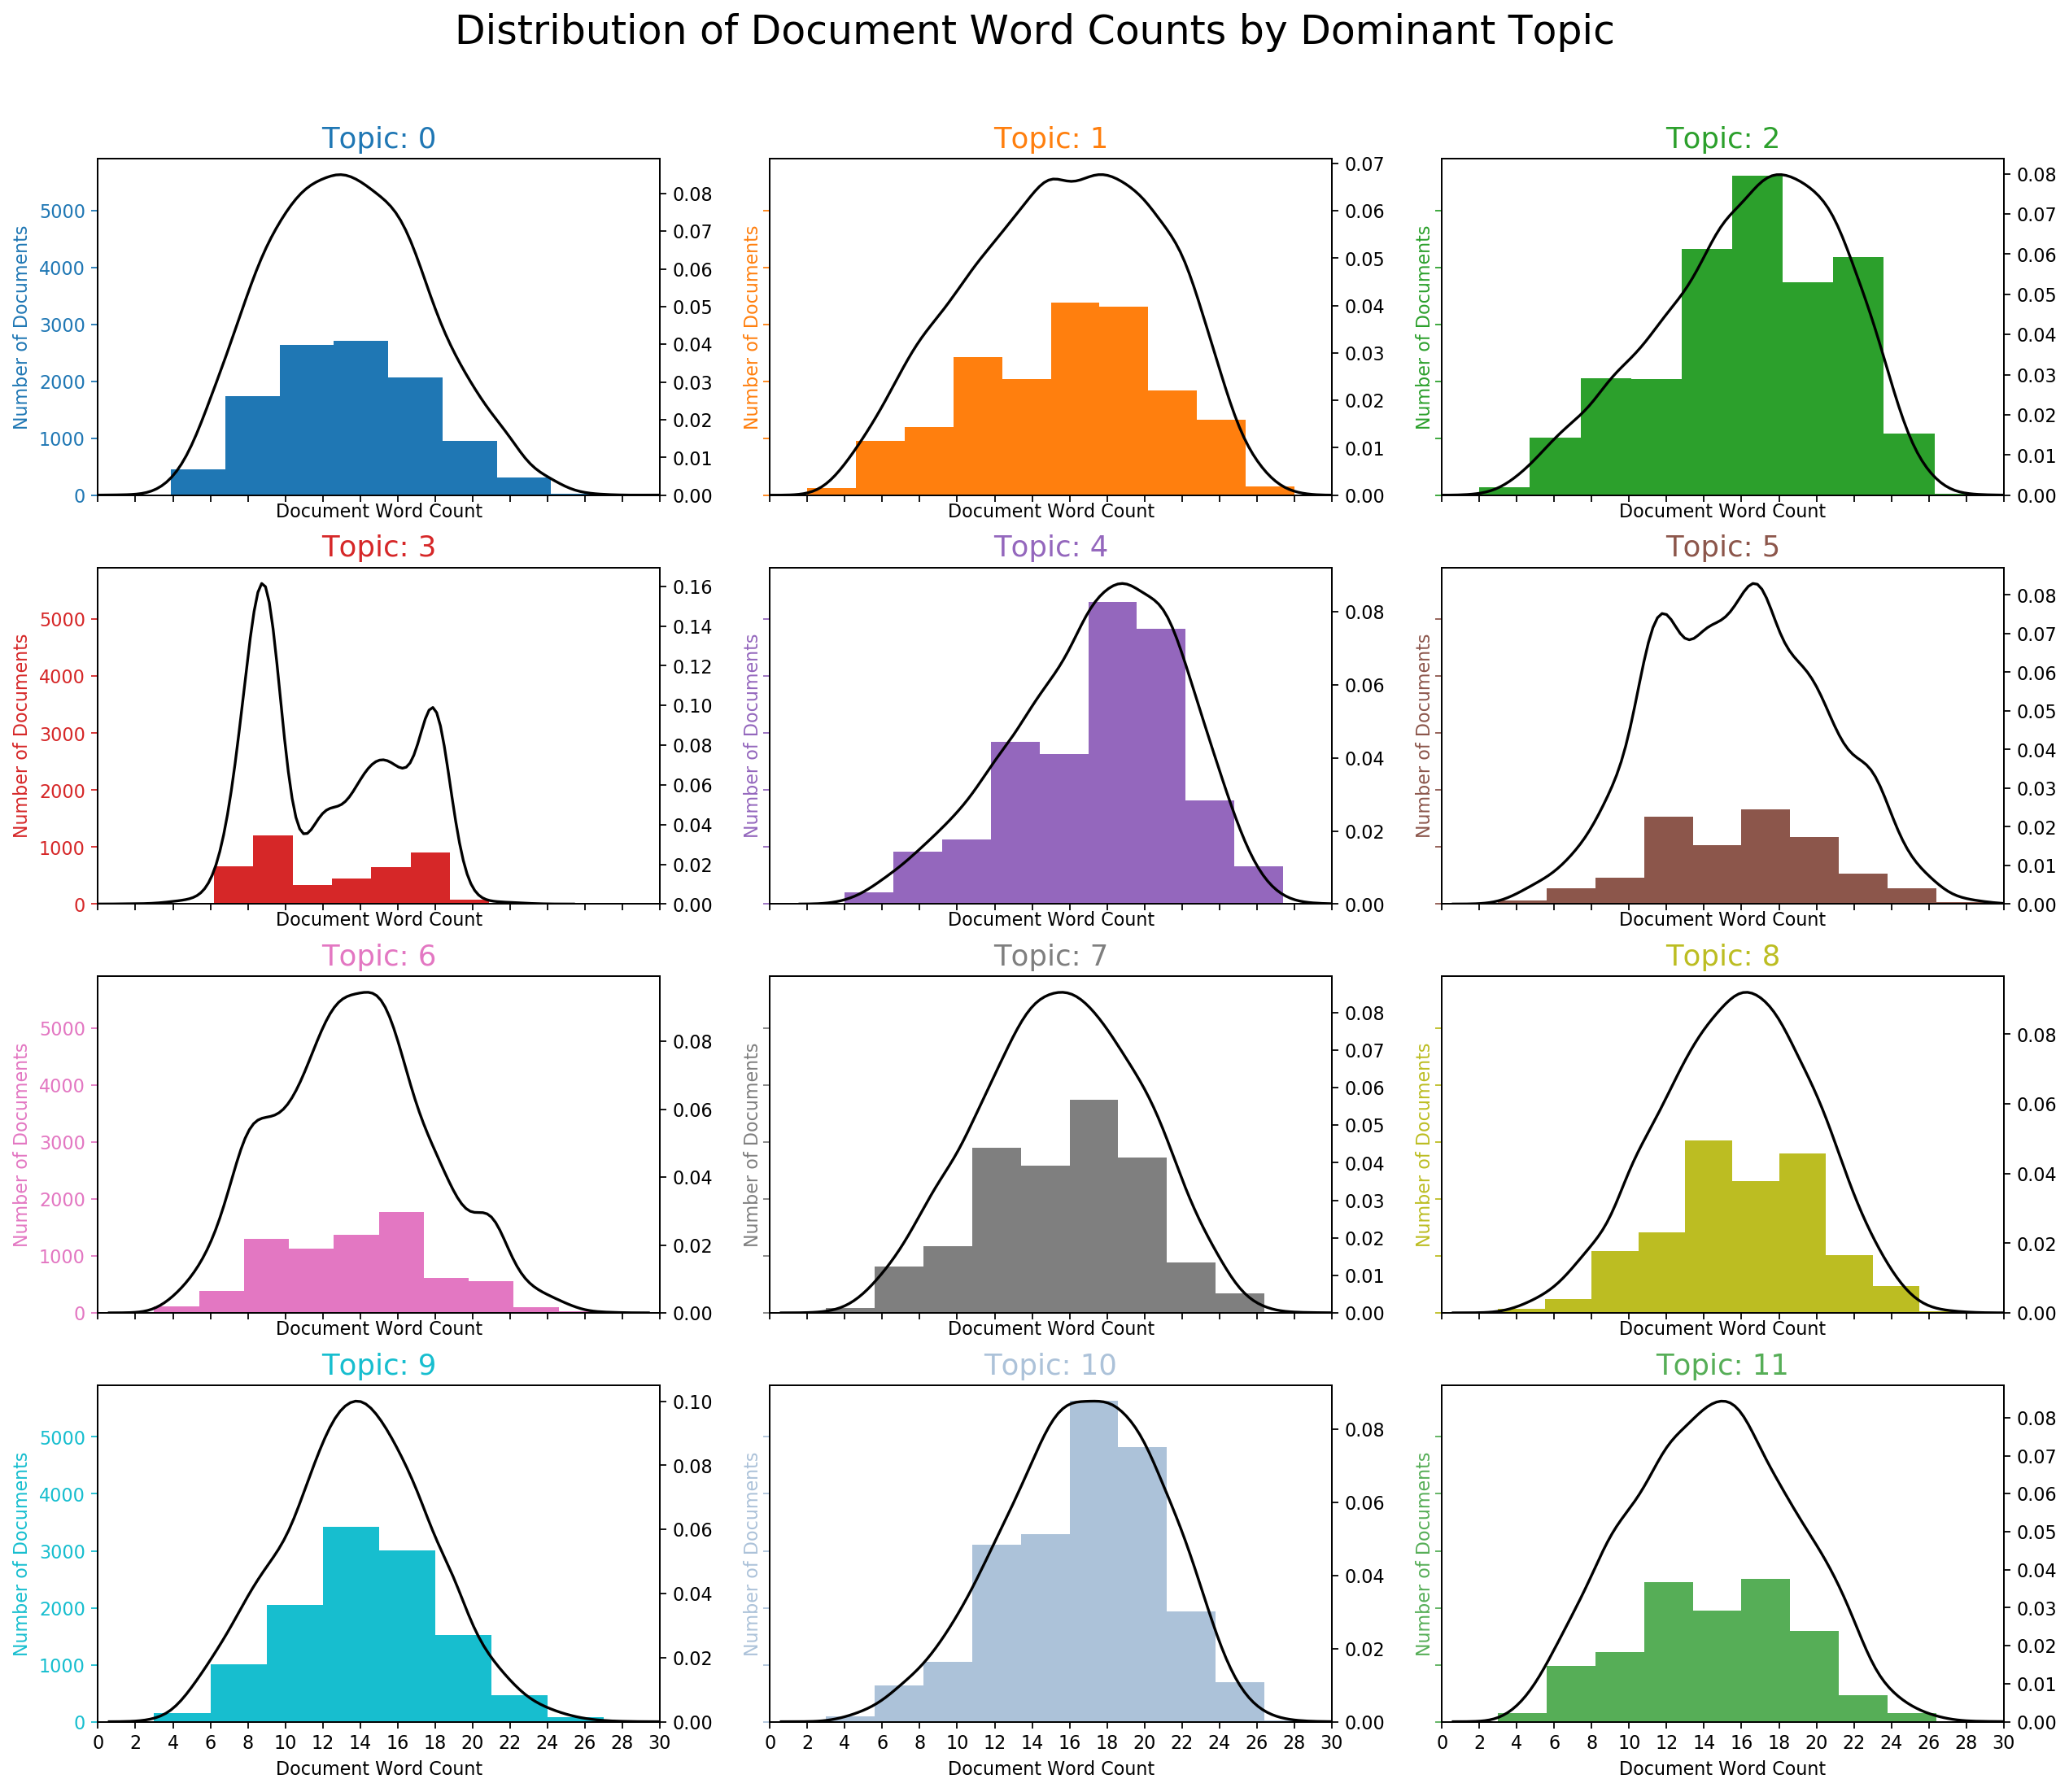

In [99]:
import seaborn as sns
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

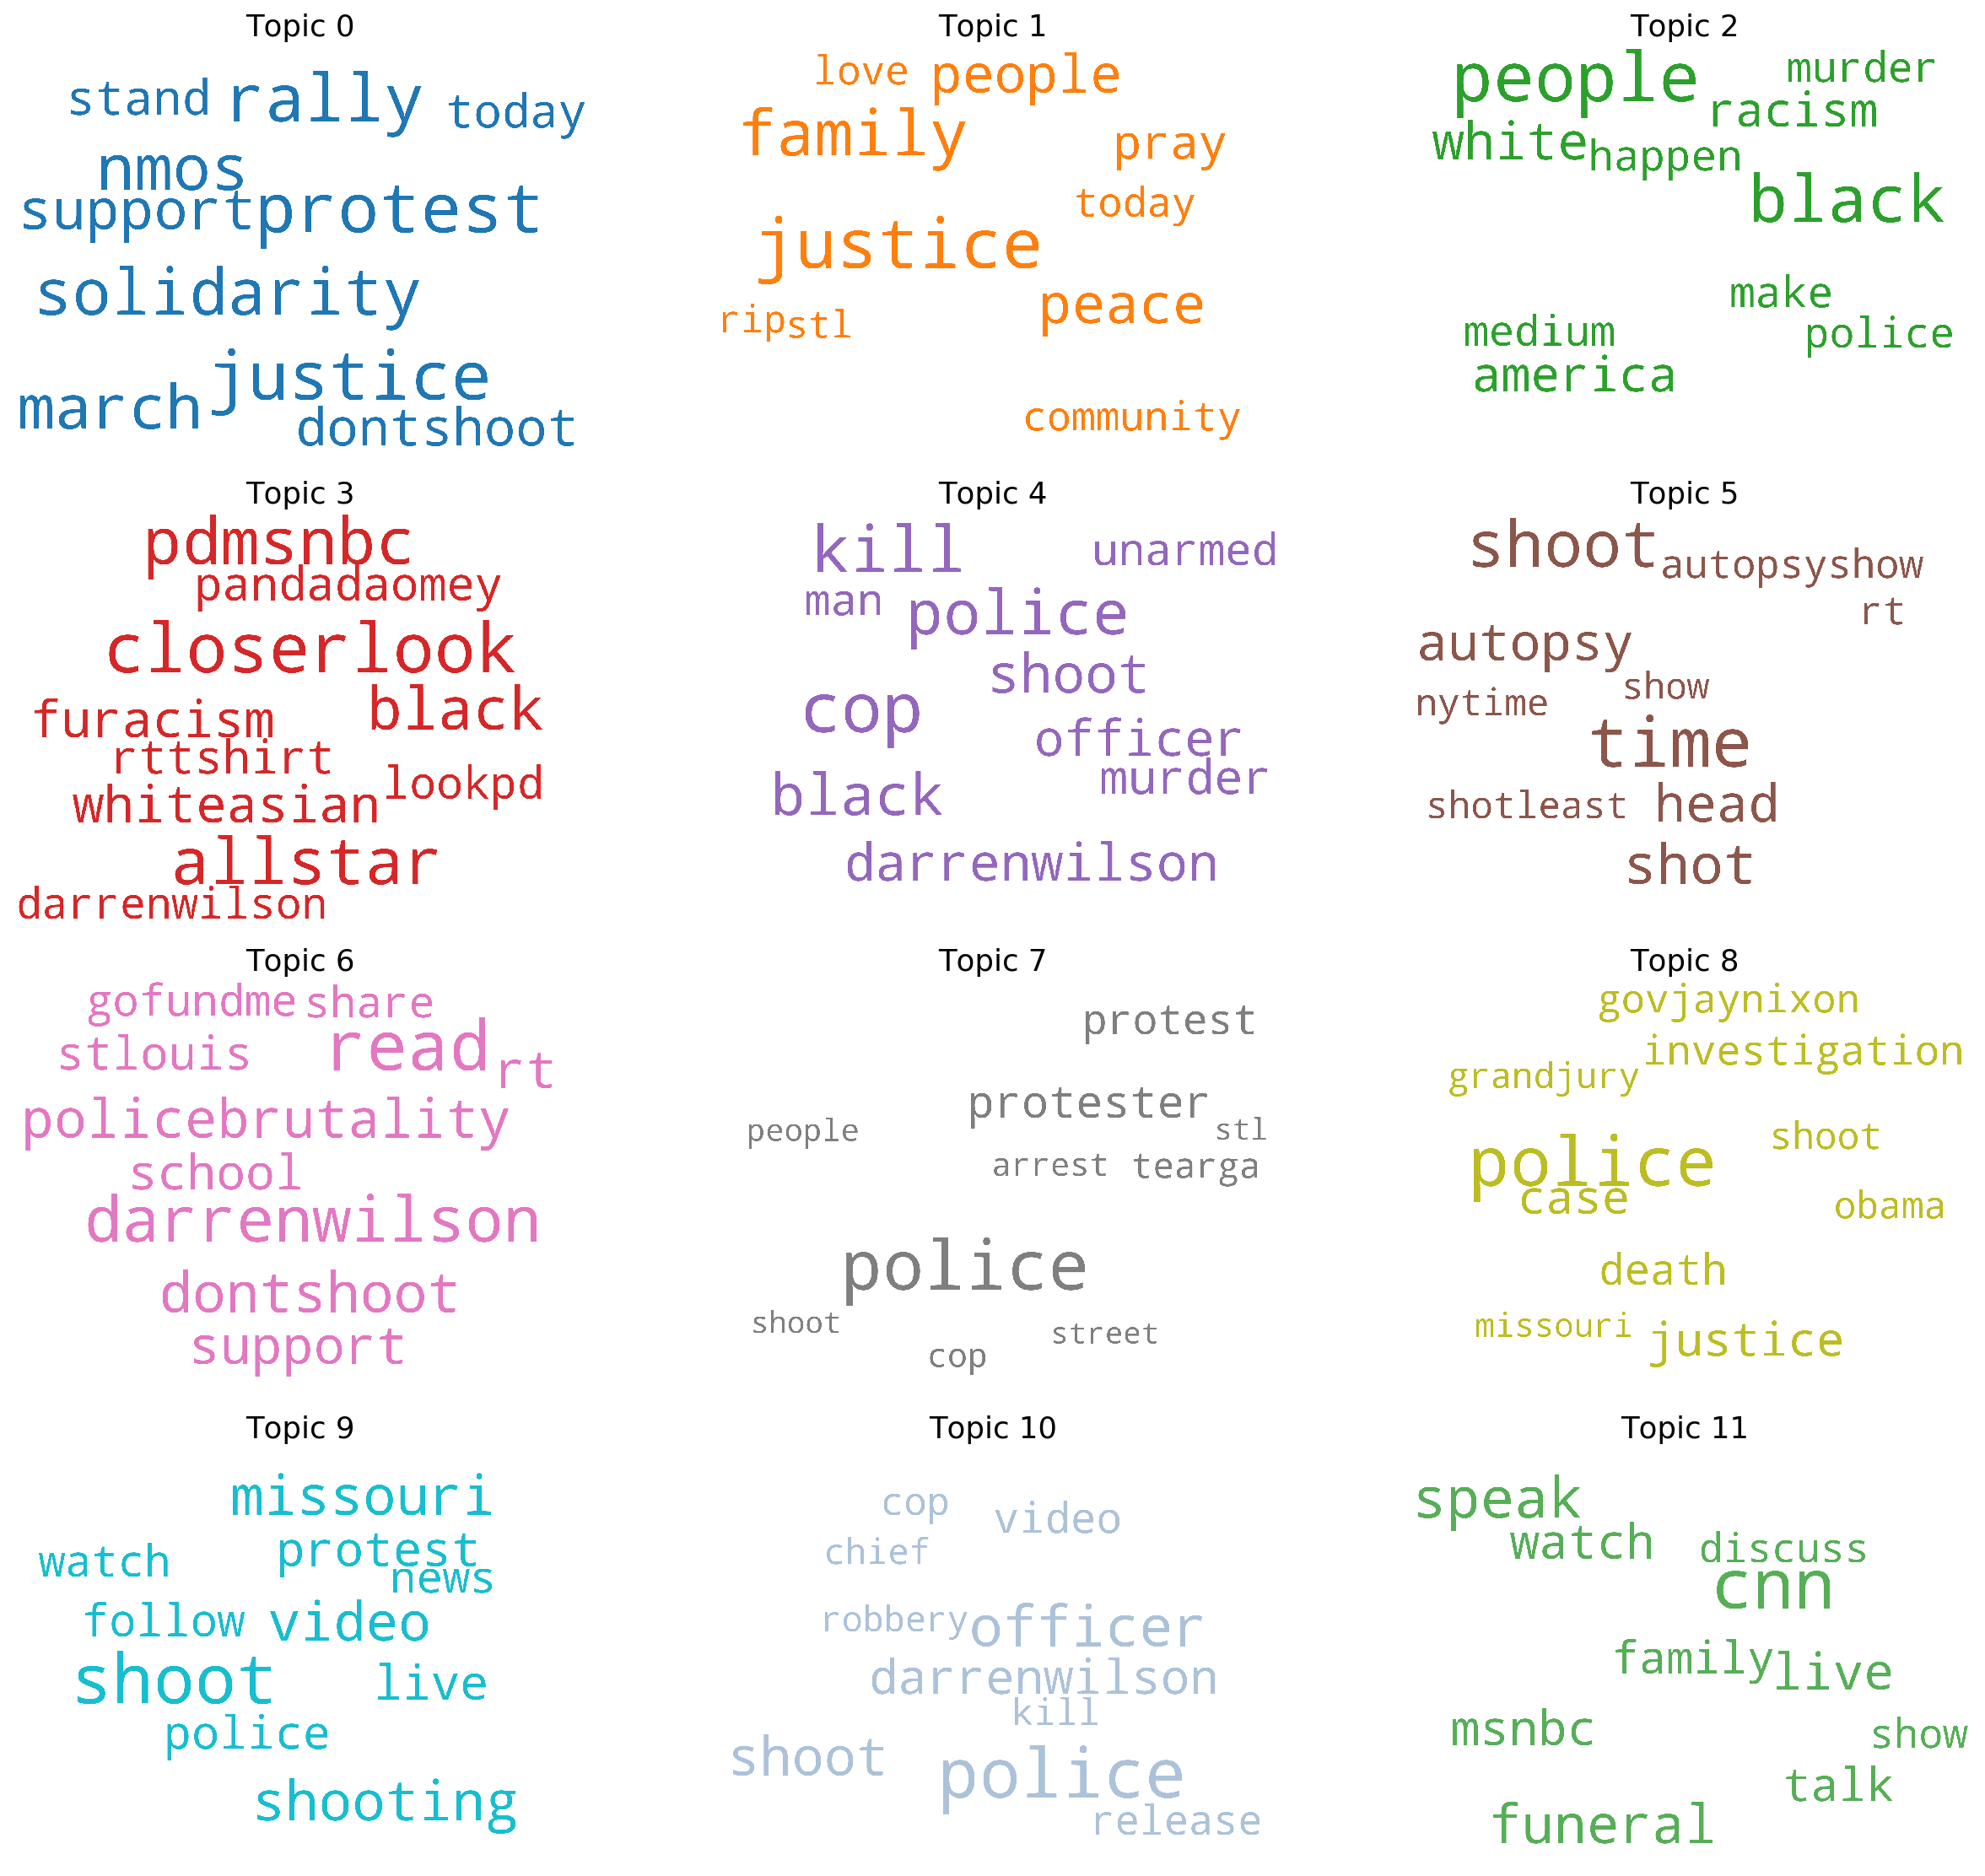

In [103]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 3, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

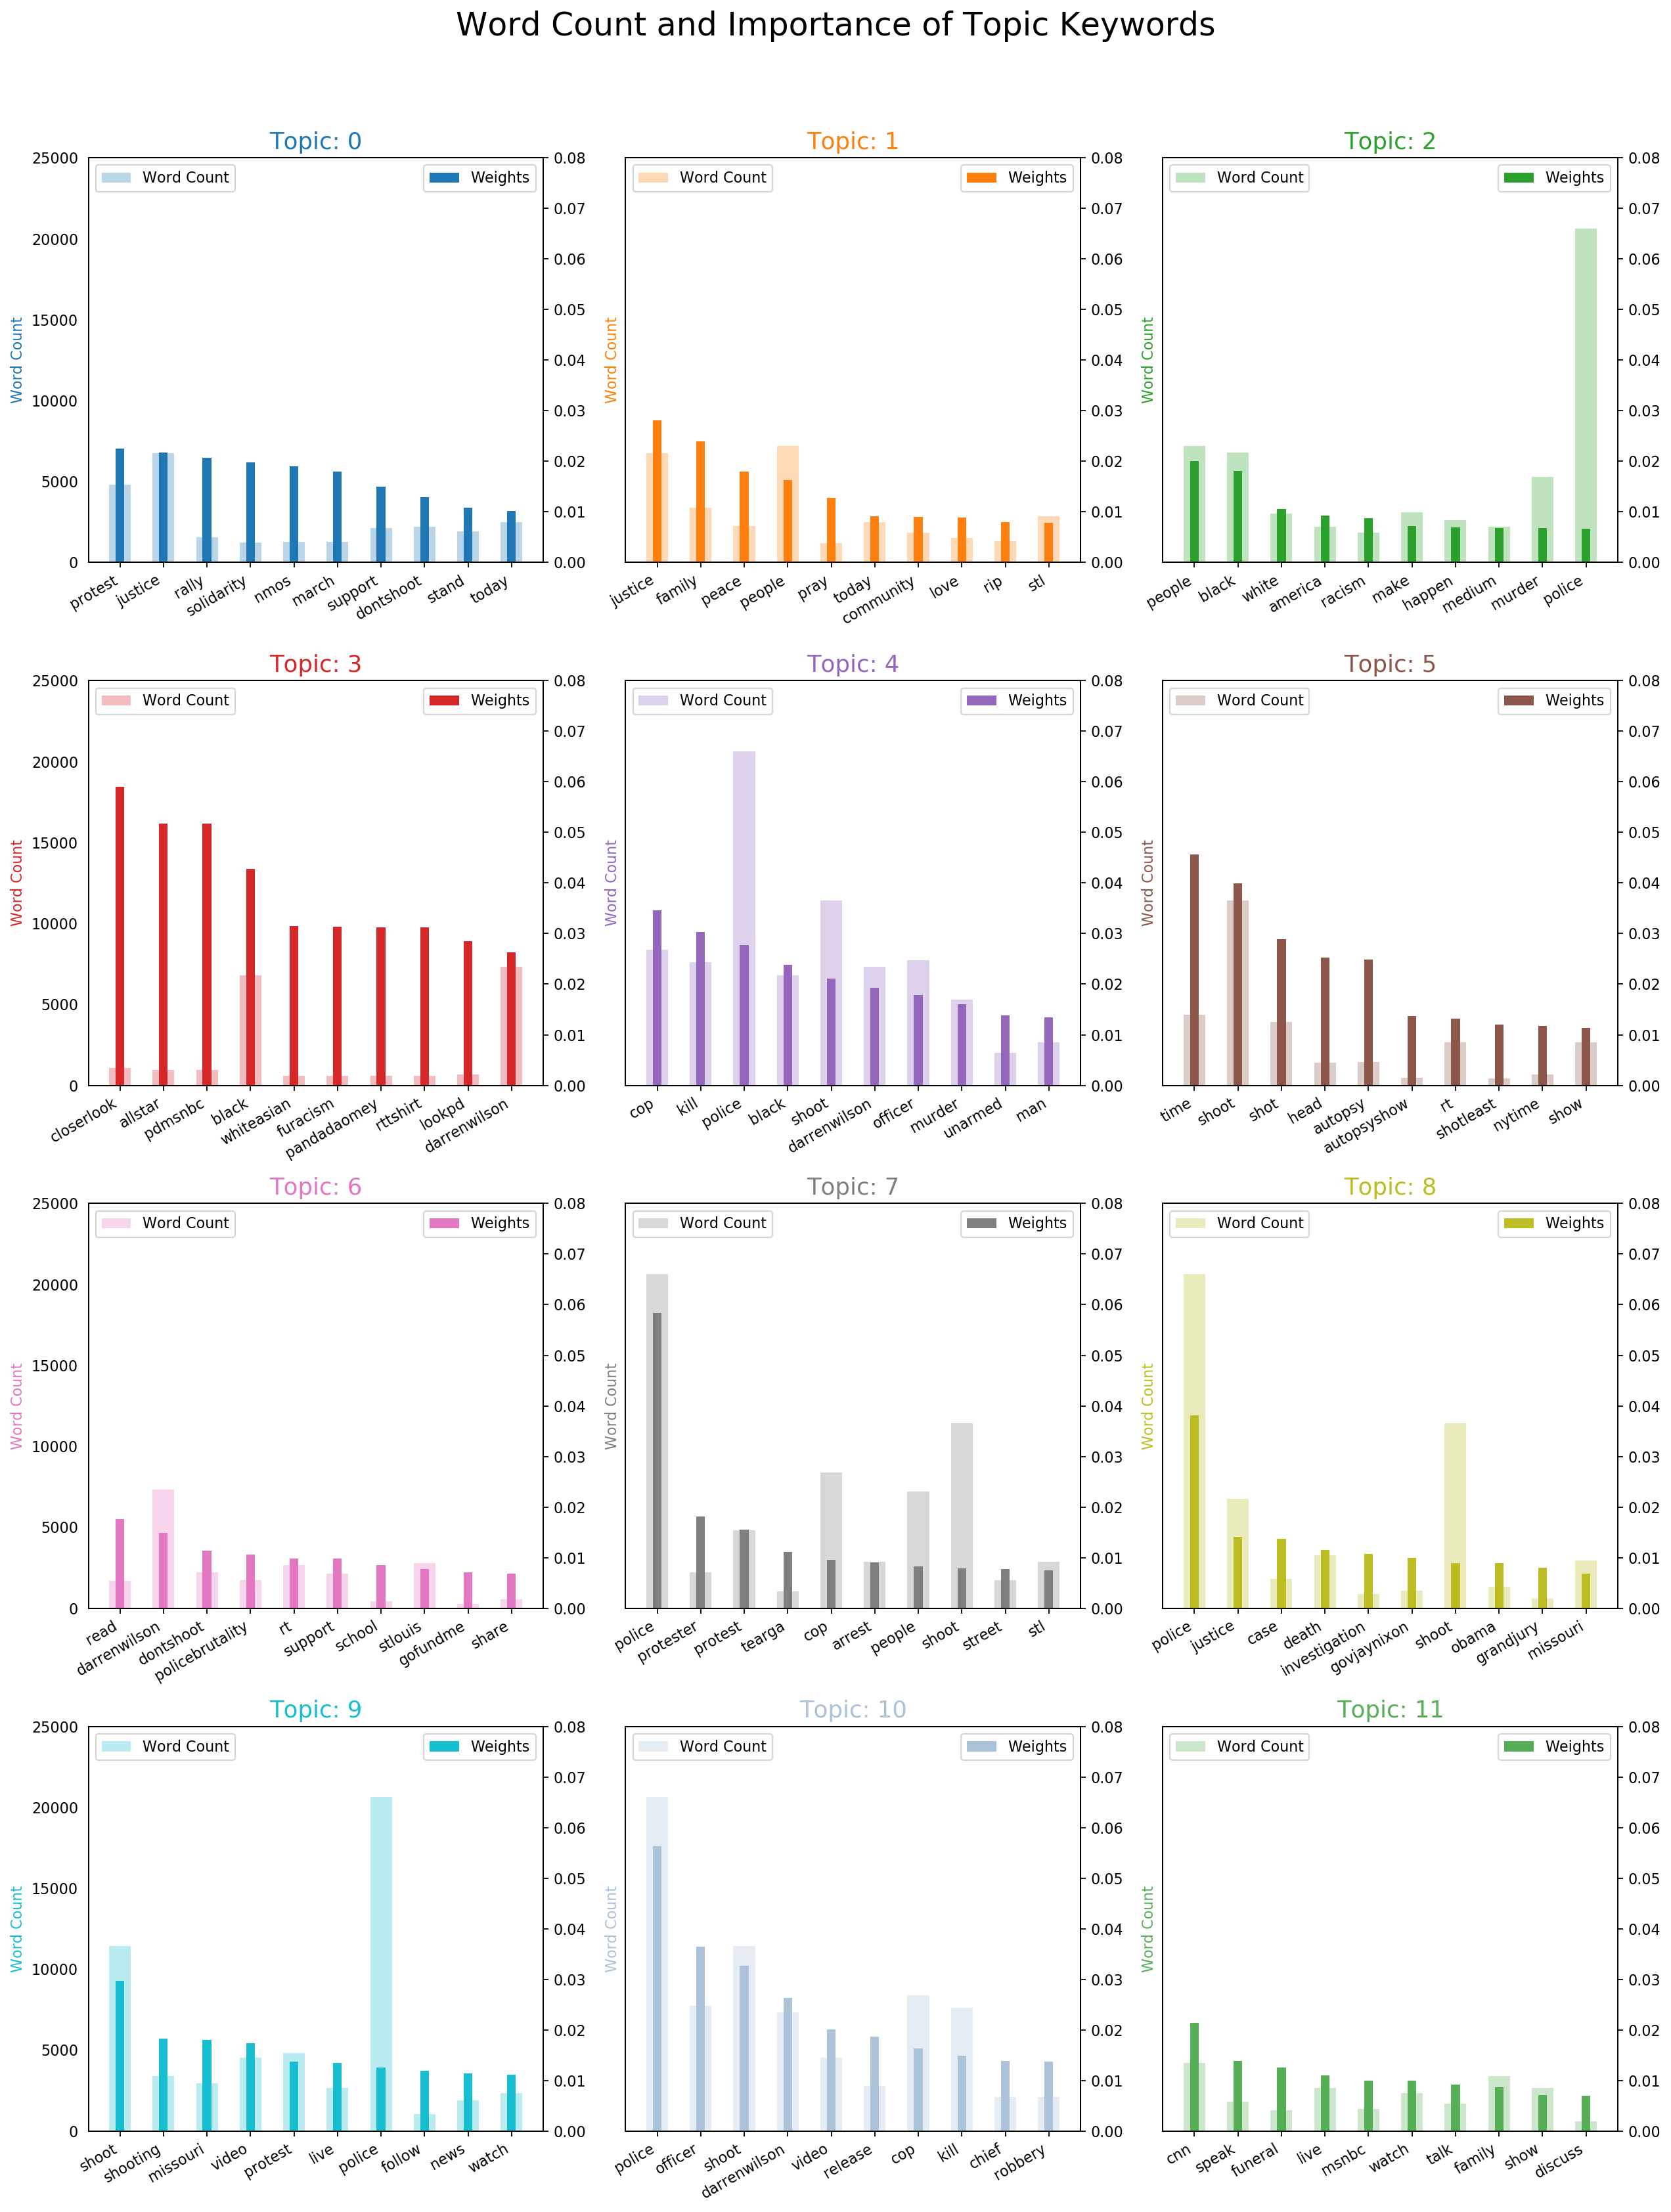

In [104]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence coloring

In [ ]:
# Sentence Coloring
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                       color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

## Upload table with tweet-topic

In [106]:
%%bigquery df_pred
SELECT 
    id,
    REGEXP_REPLACE(full_text_cleaned, "^rt ", "") AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2

In [107]:
df_pred

,id,full_text
0,503279641025851400,thebaxterbean ferguson cops busted cops hid new video that seems to show mikebrown paying for cigarillos $URL$ htt…
1,500681436626579460,thebaxterbean good question why exactly were fergusonpolice still looking for the suspect 7 hours after mikebrown was murdered? htt…
2,499016307602653200,“missbeae reports of multiple gunshots from chambers street per two officers on police scanner ferguson mikebrown” 🙌🙌🙌
3,500816995127132160,ellehoneybee i dont apologize for my blackness or your fear ferguson mikebrown $URL$
4,505865806274514940,anonymouspress michael brown sr leads family march on ferguson justiceformikebrown mikebrown nosleeptilljustice $URL$
...,...,...
792769,499913165459980300,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792770,499965811843297300,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792771,499925887488655360,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792772,499980479127650300,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …


In [108]:
data_pred = list(df_pred['full_text'])
ids_pred = list(df_pred['id'])

In [113]:
corpus_pred = create_corpus(data_pred)
df_topic_pred = format_topics_sentences(optimal_model, corpus_pred, data_pred)
df_topic_pred['id'] = ids_pred
df_topic_pred = df_topic_pred[['id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]

In [114]:
df_topic_pred

,id,Dominant_Topic,Topic_Perc_Contrib,Text
0,503279641025851400,3,0.7915,thebaxterbean ferguson cops busted cops hid new video that seems to show mikebrown paying for cigarillos $URL$ htt…
1,500681436626579460,4,0.7548,thebaxterbean good question why exactly were fergusonpolice still looking for the suspect 7 hours after mikebrown was murdered? htt…
2,499016307602653200,7,0.9441,“missbeae reports of multiple gunshots from chambers street per two officers on police scanner ferguson mikebrown” 🙌🙌🙌
3,500816995127132160,4,0.4157,ellehoneybee i dont apologize for my blackness or your fear ferguson mikebrown $URL$
4,505865806274514940,0,0.7266,anonymouspress michael brown sr leads family march on ferguson justiceformikebrown mikebrown nosleeptilljustice $URL$
...,...,...,...,...
792769,499913165459980300,2,0.9104,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792770,499965811843297300,2,0.9104,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792771,499925887488655360,2,0.9104,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792772,499980479127650300,2,0.9104,ayalaprager when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …


In [115]:
import pandas_gbq
pandas_gbq.to_gbq(df_topic_pred, 'topic_modeling.topics_ferguson_brown', project_id='dsi-capstone-f19-group-1')

1it [02:17, 137.65s/it]
